In [10]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import seaborn as sns
import threading
import os


plt.style.use('seaborn-deep')
plt.rc('grid', linestyle="--", color='gray')
# @working path
FIG_PATH     = '../tex/figs/'
WEB_FIG_PATH = '../tex/web-figs/'
DATA_PATH    = '../code/'


# @global settings
WEB_FIG_DPI  = 600
FIG_DPI      = 800
FIG_EXT      = '.pdf'
WEB_FIG_EXT  = '.png'

# @global functions
def savefig(handler,name, fig_ext = FIG_EXT, web_fig_ext = WEB_FIG_EXT):
    if name != '':
        handler.savefig(FIG_PATH + name + fig_ext, dpi = FIG_DPI,bbox_inches = 'tight', pad_inches = 0.1)
    #handler.savefig(WEB_FIG_PATH + name + web_fig_ext, dpi = WEB_FIG_DPI,bbox_inches = 'tight', pad_inches = 0.1)

Populating the interactive namespace from numpy and matplotlib


/home/yihan/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['savefig']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [45]:

PC     = 648000/np.pi
KPC    = 1000*PC 
AU     = 1
MS     = 1
YR     = 2 * np.pi
Hubble_t = 13.4e9*YR
V_UNIT = 2.9784651272402163E1
KMS    = 1.0/V_UNIT
lc     = 299792.458/V_UNIT
DAY    = YR/365.25636042
HR     = DAY/24
G= 1

In [46]:
def load_orbit(data,orbit_name):
    name = ['m1', 'm2', 'p', 'e', 'i', 'Omega', 'omega', 'nv']
    orbit={}
    for key, i in zip(name, range(len(name))):
        orbit.update({orbit_name+key : data[:,i]})
    return orbit

def load_incid_args(data):
    return {'v_inf': data[:,0], 'b':data[:,1], 'w':data[:,2], 'ii':data[:,3],'iphi':data[:,4]}

def load_post_scattered(data, obj_name):
    dic = {'time':data[:,0]}
    for name, idx in zip(obj_name, range(len(obj_name))):
        offset = 10*idx
        dic.update({'m_{' + name + '}': data[:,offset + 3],
                    'r_{' + name + '}': data[:,offset + 4],
                    'px_{' + name + '}': data[:,offset + 5],
                    'py_{' + name + '}': data[:,offset + 7],
                    'pz_{' + name + '}': data[:,offset + 7],
                    'vx_{' + name + '}': data[:,offset + 8],
                    'vy_{' + name + '}': data[:,offset + 9],
                    'vz_{' + name + '}': data[:,offset + 10]
                   })
    return dic
        
def load_closest(data, obj_name):
    dic ={}
    for name, idx in zip(obj_name, range(len(obj_name))):
        offset = 6*idx
        dic.update({'closest:px_{' + name + '}': data[:,offset + 0],
                    'closest:py_{' + name + '}': data[:,offset + 1],
                    'closest:pz_{' + name + '}': data[:,offset + 2],
                    'closest:vx_{' + name + '}': data[:,offset + 3],
                    'closest:vy_{' + name + '}': data[:,offset + 4],
                    'closest:vz_{' + name + '}': data[:,offset + 5]})
    return dic
        
def load_data(fname, os, objname):
    data = np.loadtxt(fname)
    
    dic = {}
    dic.update(load_orbit(data[:,os['incident-orbit-s']:os['incident-orbit-e']],'incident-orbit-') )
    #dic.update(load_incid_args(data[:,os['incident-s']:os['incident-e']]))
    
    dic.update(load_post_scattered(data[:,os['post-s']:os['post-e']], objname))
    
    if 'closest-s' and 'closest-e' in os:
        dic.update(load_closest(data[:,os['closest-s']:os['closest-e']], objname))
    
    if 'sn-orbit-s' and 'sn-orbit-e' in os:
        dic.update(load_orbit(data[:,os['sn-orbit-s']:os['sn-orbit-e']],'sn-orbit-'))
        
    if 'ss-orbit-s' and 'ss-orbit-e' in os:
        dic.update(load_orbit(data[:,os['ss-orbit-s']:os['ss-orbit-e']],'ss-orbit-'))
        
    return dic


def get_a_e(m, drx, dry, drz, dvx, dvy, dvz):
    r  = np.sqrt(drx**2 + dry**2 + drz**2)
    v2 = dvx**2 + dvy**2 + dvz**2
    v  = np.sqrt(v2)
    
    vrdot = drx*dvx + dry*dvy + drz*dvz
    
    vdfsq = (v2 - m / r)
    ex = (vdfsq * drx - vrdot * dvx)
    ey = (vdfsq * dry - vrdot * dvy) 
    ez = (vdfsq * drz - vrdot * dvz) 
    e  = np.sqrt(ex * ex + ey * ey + ez * ez) / m
    a  = -m / (v2 - 2 * m/r)
    return a, e


def calc_pair_a_e(data, pairs):
    dic = {}
    for name_i, name_j in pairs:
        mi = data['m_{' + name_i + '}']
        mj = data['m_{' + name_j + '}']
        
        dpx = data['px_{' + name_i + '}'] - data['px_{' + name_j + '}']
        dpy = data['py_{' + name_i + '}'] - data['py_{' + name_j + '}']
        dpz = data['pz_{' + name_i + '}'] - data['pz_{' + name_j + '}']
        
        dvx = data['vx_{' + name_i + '}'] - data['vx_{' + name_j + '}']
        dvy = data['vy_{' + name_i + '}'] - data['vy_{' + name_j + '}']
        dvz = data['vz_{' + name_i + '}'] - data['vz_{' + name_j + '}']
        

        a, e = get_a_e(mi + mj, dpx, dpy, dpz, dvx, dvy, dvz)
        dic.update({'a_{' + name_i + ',' + name_j + '}': a,  'e_{' + name_i + ',' + name_j + '}': e})
    return dic
        
def calc_tidal_t_scale(data, star_name, planet_name='j'):
    mp = data['m_{'+planet_name+ '}']
    rp = data['r_{'+planet_name+ '}']
    dic = {}
    for name in star_name:
        rs = data['r_{' + name + '}']
        ms = data['m_{' + name + '}']
        #s = 9.0/4/2e7*mp/ms*rs**5
        p = 9.0/4/2.5e4*ms/mp*rp**5
        a = data['a_{' + name + ',' + planet_name + '}']
        e = data['e_{' + name + ',' + planet_name + '}']
        n = np.sqrt( G*(ms+mp)/a**3)
        tau_ap = 3/n*a**5/14/e**2/p
        dic.update({'T_{' + name + ',' + planet_name + '}' : tau_ap})
    return dic

def check_collision(data, pairs):
    dic ={}
    for name_i, name_j in pairs:
        ri = data['r_{' + name_i + '}']
        rj = data['r_{' + name_j + '}']
        
        dpx = data['px_{' + name_i + '}'] - data['px_{' + name_j + '}']
        dpy = data['py_{' + name_i + '}'] - data['py_{' + name_j + '}']
        dpz = data['pz_{' + name_i + '}'] - data['pz_{' + name_j + '}']
        
        
        coll = (dpx**2 + dpy**2 + dpz**2) <= (ri + rj)**2
        
        
        data['star outcome'][coll] = 'coll_{' + name_i + ',' + name_j + '}'
        data['planet outcome'][coll] = 'coll_{' + name_i + ',' + name_j + '}'
        #dic.update({'coll_{' + name_i + ',' + name_j + '}': coll})
    #return dic

def classify_star_outcome(data, star_pairs):
    init_bound = np.ones(data['time'].shape, dtype=bool)
    init_unbound =np.ones(data['time'].shape, dtype=bool)
    disrupted = np.zeros(data['time'].shape, dtype=bool)
    
    for name_i, name_j in star_pairs:
        if (name_i == 's1') and (name_j == 's2'):
            a = data['a_{' + name_i + ',' + name_j + '}']
            e = data['e_{' + name_i + ',' + name_j + '}']
        
            bound = (a > 0) & (0 <=e) & (e < 1)
            unbound = (e >= 1) & (a <= 0) 
            init_bound = init_bound & bound
            init_unbound=init_unbound&unbound
            disrupted = np.ones(data['time'].shape, dtype=bool)
    
    
    flyby = np.ones(data['time'].shape, dtype=bool)
    
    bi_formation ={}
    for name_i, name_j in star_pairs:
        if (name_i != 's1') or (name_j != 's2'):
            a = data['a_{' + name_i + ',' + name_j + '}']
            e = data['e_{' + name_i + ',' + name_j + '}']
        
            bound = (a > 0) & (0 <=e) & (e < 1)
            unbound = (e >= 1) & (a <= 0) 
            
            bi_formation.update({'reunion_{' + name_i + ',' + name_j + '}': bound & init_unbound})
        
            flyby = flyby & unbound & init_bound
            
            disrupted = disrupted & unbound & init_unbound
        
    reunion = np.zeros(data['time'].shape, dtype=bool)
    for key, r in bi_formation.items():
        reunion = reunion | r
        
    data['star outcome'][reunion] = 'reunion'
    data['star outcome'][flyby]  = 'flyby'
    data['star outcome'][disrupted] = 'disrupted'
    
    #dic = {'reunion':reunion, 'flyby' : flyby, 'disrupted': disrupted}
    
    #dic.update(bi_formation)
            
    #return dic

def classify_planet_outcome(data, star_names, planet_name='j', a_final=0.1*AU):
    binary = []
    for star_name in star_names:
        a = data['a_{' + star_name + ',' + planet_name + '}']
        e = data['e_{' + star_name + ',' + planet_name + '}']
        tau_ap = data['T_{' + star_name + ',' + planet_name + '}']
        
        bound = (a > 0) & (0 <=e) & (e < 1)
        unbound = (e >= 1) & (a <= 0) 
        hot_jupiter_candi = (a*(1-e*e) < a_final) & (tau_ap < Hubble_t) 
        binary.append((star_name, bound, unbound, hot_jupiter_candi))
        
    dic={}
    for star_name1, bound1, unbound1, hj1 in binary:
        bound = bound1
        hot_jupiter = hj1
        for star_name2, bound2, unbound2, hj2 in binary:
            if(star_name1 != star_name2):
                bound = bound & unbound2
                hot_jupiter = hot_jupiter & unbound2
                
        data['planet outcome'][bound] = 'stay_{' + star_name1 + ',' + planet_name + '}'
        data['planet outcome'][hot_jupiter] = 'HJ_{' + star_name1 + ',' + planet_name + '}' 
    
        #dic.update({'stay_{' + star_name1 + ',' + planet_name + '}' : bound, 'HJ_{' + star_name1 + ',' + planet_name + '}' : hot_jupiter})
        
    ejection = np.ones(data['time'].shape, dtype=bool)
    for star_name, bound, unbound, hj in binary:
        ejection = ejection & unbound
        
    data['planet outcome'][ejection] = 'ejection_{'+planet_name+'}'
    
    
def post_process(fname, oss, objname, pairs):
    star_name = [ name for name in objname if name.startswith('s')]
    planet_name = [ name for name in objname if not name.startswith('s')]
    star_pairs = [(s1, s2) for s1, s2 in pairs if s1.startswith('s') and s2.startswith('s')]
    
    #print(star_name, planet_name, star_pairs)
    
    if os.path.exists(fname) == False:
        return
    
    data = load_data(fname, oss, objname)
    
    data.update({'star outcome':np.zeros(data['time'].shape,dtype = object)})
    data.update({'planet outcome':np.zeros(data['time'].shape,dtype = object)})
    data.update(calc_pair_a_e(data, pairs))
    
    classify_star_outcome(data, star_pairs)
   
    
    for p_name in planet_name:
        data.update(calc_tidal_t_scale(data, star_name, p_name))
        classify_planet_outcome(data, star_name, p_name)
        
    check_collision(data, pairs)
    
    return data

def get_ss_final_data(v_inf, aj, df):
    p = df['incident-orbit-p']
    e = df['incident-orbit-e']
    b = p / np.sqrt(e**2 - 1)
    b_max = b[np.isfinite(b)].max()
    
    pfate = df['planet outcome']
    sfate = df['star outcome']
    
    ej = pfate == 'ejection_{j}'
    
    coll_ss = (sfate== 'coll_{s,s1}' )
    coll_sj = (pfate == 'coll_{s,j}') | (pfate == 'coll_{s1,j}')
    
    stay = pfate == 'stay_{s,j}'
    capture = pfate == 'stay_{s1,j}'
    
    ntot = len(pfate)
    
    return v_inf, aj, b_max, ej.sum()/ntot, coll_ss.sum()/ntot, coll_sj.sum()/ntot, stay.sum()/ntot, capture.sum()/ntot

def get_sb_final_data(df, v_inf, aj):
    
    p = df['incident-orbit-p']
    e = df['incident-orbit-e']
    b = p / np.sqrt(e**2 - 1)
    b_max = b[np.isfinite(b)].max()
    
    pfate = df['planet outcome']
    sfate = df['star outcome']
    
    ej = pfate == 'ejection_{j}'
    
    coll_ss = (sfate== 'coll_{s,s1}' ) | (sfate== 'coll_{s,s2}' ) | (sfate== 'coll_{s1,s2}' )
    coll_sj = (pfate == 'coll_{s,j}') | (pfate == 'coll_{s1,j}') | (pfate == 'coll_{s2,j}')
    
    stay = pfate == 'stay_{s,j}'
    
    s_capture = ( (pfate == 'stay_{s1,j}') & (sfate == 'disrupted') ) | ( (pfate == 'stay_{s2,j}') & (sfate == 'disrupted') )
    
    b_capture = ( (pfate == 'stay_{s1,j}') & ( (sfate == 'flyby') | (sfate == 'reunion') )) | ( (pfate == 'stay_{s2,j}') & ( (sfate == 'flyby') | (sfate == 'reunion') ))
    
    
    ntot = len(pfate)
    
    return v_inf, aj, b_max, ej.sum()/ntot, coll_ss.sum()/ntot, coll_sj.sum()/ntot, stay.sum()/ntot, s_capture.sum()/ntot, b_capture.sum()/ntot
    
def get_bs_final_data(df, v_inf, aj):
    
    p = df['incident-orbit-p']
    e = df['incident-orbit-e']
    b = p / np.sqrt(e**2 - 1)
    b_max = b[np.isfinite(b)].max()
    
    pfate = df['planet outcome']
    sfate = df['star outcome']
    
    ej = pfate == 'ejection_{j}'
    
    coll_ss = (sfate== 'coll_{s,s1}' ) | (sfate== 'coll_{s,sb}' ) | (sfate== 'coll_{s1,sb}' )
    coll_sj = (pfate == 'coll_{s,j}') | (pfate == 'coll_{s1,j}') | (pfate == 'coll_{sb,j}')
    
    stay = pfate == 'stay_{s,j}'
    
    capture = pfate == 'stay_{s1,j}'
    
    trans = pfate == 'stay_{sb,j}'
    
    print('here')
    
    ntot = len(pfate)
    
    return v_inf, aj, b_max, ej.sum()/ntot, coll_ss.sum()/ntot, coll_sj.sum()/ntot, stay.sum()/ntot, capture.sum()/ntot, trans.sum()/ntot

def get_bb_final_data(df, v_inf, aj):
    
    p = df['incident-orbit-p']
    e = df['incident-orbit-e']
    b = p / np.sqrt(e**2 - 1)
    b_max = b[np.isfinite(b)].max()
    
    pfate = df['planet outcome']
    sfate = df['star outcome']
    
    ej = pfate == 'ejection_{j}'
    
    coll_ss = (sfate== 'coll_{s,s1}' ) | (sfate== 'coll_{s,s2}' ) | (sfate== 'coll_{s1,s2}' ) | (sfate== 'coll_{s,sb}' ) | (sfate== 'coll_{sb,s1}' )| (sfate== 'coll_{sb,s2}' )
    coll_sj = (pfate == 'coll_{s,j}') | (pfate == 'coll_{s1,j}') | (pfate == 'coll_{s2,j}')
    
    stay = pfate == 'stay_{s,j}'
    
    s_capture = ( (pfate == 'stay_{s1,j}') & (sfate == 'disrupted') ) | ( (pfate == 'stay_{s2,j}') & (sfate == 'disrupted') )
    
    b_capture = ( (pfate == 'stay_{s1,j}') & ( (sfate == 'flyby') | (sfate == 'reunion') )) | ( (pfate == 'stay_{s2,j}') & ( (sfate == 'flyby') | (sfate == 'reunion') ))
    
    trans = pfate == 'stay_{sb,j}'
    
    ntot = len(pfate)
    
    return v_inf, aj, b_max, ej.sum()/ntot, coll_ss.sum()/ntot, coll_sj.sum()/ntot, stay.sum()/ntot, s_capture.sum()/ntot, b_capture.sum()/ntot, trans.sum()/ntot

In [102]:
import csv
def write_list_to_file(data, filename):
    """Write the list to csv file."""
    with open(filename,'w') as out:
        csv_out=csv.writer(out)
        #csv_out.writerow(['name','num'])
        for row in data:
            csv_out.writerow(row)

In [ ]:
v=np.array([0.1, 3.42222222,  6.74444444,  10.06666667, 13.38888889, 16.71111111, 20.03333333, 23.35555556, 26.67777778, 30])

v_name =['0.1', '3.4', '6.7', '10.1', '13.4', '16.7', '20.0', '23.4', '26.7', '30.0']
a_j = ['0.1', '0.5', '1.0', '1.5', '2.0', '2.5', '3.0', '3.5', '4.0', '4.5', '5.0']

In [47]:
prefix = '../code/ss/solar-normal-ss_ss_'

ss_idx = {'incident-orbit-s' : 40, 'incident-orbit-e':48, 'post-s':1, 'post-e':32}

ss_names = ['s','j', 's1']

ss_pairs = [('s','j'), ('s','s1'), ('s1','j')]
df01 = pd.DataFrame(post_process(prefix+'0.1_0.1.txt', ss_idx, ss_names, ss_pairs))

df05 = pd.DataFrame(post_process(prefix+'0.1_0.5.txt', ss_idx, ss_names, ss_pairs))

df1 = pd.DataFrame(post_process(prefix+'0.1_1.0.txt', ss_idx, ss_names, ss_pairs))

df2 = pd.DataFrame(post_process(prefix+'0.1_2.0.txt', ss_idx, ss_names, ss_pairs))

/home/yihan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in sqrt
/home/yihan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:186: RuntimeWarning: invalid value encountered in less


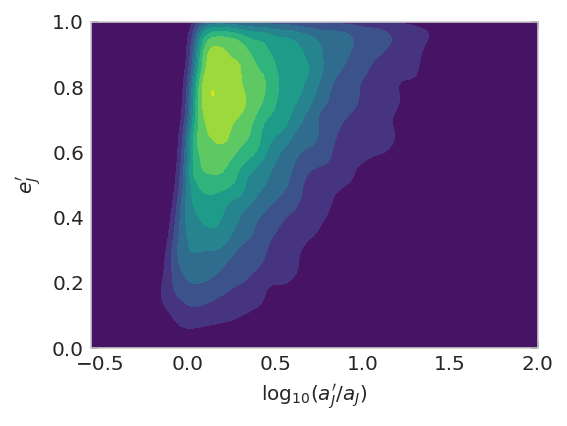

In [176]:
def show_obt_prop(df,name,a0):
    cap = df['planet outcome'] == 'stay_{s1,j}'
    a_c = df['a_{s1,j}']
    e_c = df['e_{s1,j}']
    cap = cap & (a_c[cap] < 200)
   
    
    fig=plt.figure(figsize=(4, 3))
    ax=sns.kdeplot(np.log10(a_c[cap]/a0), e_c[cap],clip=((-1, 2.0),(0,1)), cmap='viridis',shade=True)
    ax.set(xlabel='$\log_{10}(a_J^\prime/a_J)$', ylabel='$e_J^\prime$')

    savefig(plt,name)
    
show_obt_prop(df01,'ss-prop-0.1',0.1)

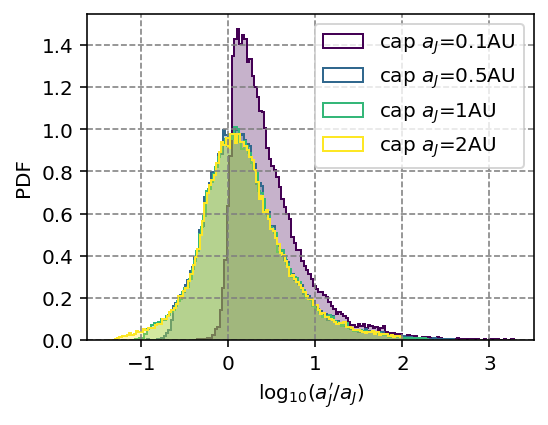

In [55]:
def a_hist(dfs,a0s):
    colors = cm.viridis(np.linspace(0,1,len(dfs)))
    fig=plt.figure(figsize=(4,3))
    for df, a0,color in zip(dfs,a0s,colors):
        #cap = df['planet outcome'] == 'stay_{s,j}'
        #a_c = df['a_{s,j}']
        #e_c = df['e_{s1,j}']
        #cap = cap & (a_c[cap] < 200)
        
        #plt.hist(np.log10(a_c[cap]/a0),bins='auto',histtype='step',density=True,color=color,label='stay $a_J$='+str(a0)+'AU')
        #plt.hist(np.log10(a_c[cap]/a0),bins='auto',histtype='stepfilled',density=True,alpha=0.3,color=color,label='$a_J$='+str(a0)+'AU')
        
        
        cap = df['planet outcome'] == 'stay_{s1,j}'
        a_c = df['a_{s1,j}']
        e_c = df['e_{s1,j}']
        cap = cap & (a_c[cap] < 200)
        
        
        plt.hist(np.log10(a_c[cap]/a0),bins='auto',histtype='step',density=True,color=color,label='cap $a_J$='+str(a0)+'AU',ls='-')
        plt.hist(np.log10(a_c[cap]/a0),bins='auto',histtype='stepfilled',density=True,color=color,alpha=0.3)
        
        
        plt.legend()
        plt.xlabel('$\log_{10}(a_J^\prime/a_J)$')
        plt.ylabel('PDF')
        plt.grid(True)
        savefig(plt,'post-a')
        
a_hist([df01, df05, df1, df2],[0.1,0.5,1,2])

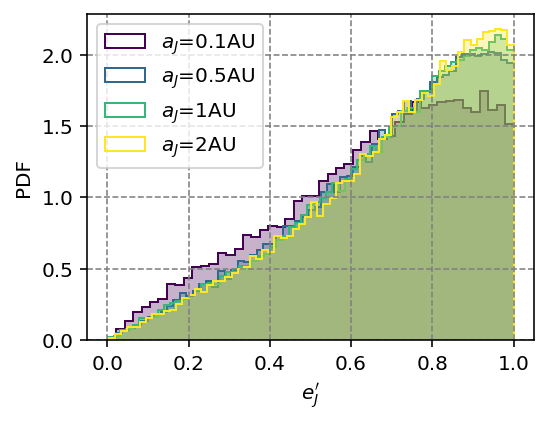

In [62]:
def e_hist(dfs,a0s):
    colors = cm.viridis(np.linspace(0,1,len(dfs)))
    fig=plt.figure(figsize=(4,3))
    for df, a0,color in zip(dfs,a0s,colors):
        cap = df['planet outcome'] == 'stay_{s1,j}'
        a_c = df['a_{s1,j}']
        e_c = df['e_{s1,j}']
        cap = cap & (a_c[cap] < 200)
        
        plt.hist((e_c[cap]),bins='auto',histtype='step',density=True,color=color,label='$a_J$='+str(a0)+'AU')
        plt.hist((e_c[cap]),bins='auto',histtype='stepfilled',density=True,alpha=0.3,color=color)
        plt.legend(loc=2)
        plt.xlabel('$e_J^\prime$')
        plt.ylabel('PDF')
    plt.grid(True)
    savefig(plt,'post-e')
    
     
e_hist([df01, df05, df1, df2],[0.1,0.5,1,2])

In [175]:
prefix = '../code/ss/solar-normal-ss_ss_'

ss_idx = {'incident-orbit-s' : 40, 'incident-orbit-e':48, 'post-s':1, 'post-e':32}

ss_names = ['s','j', 's1']

ss_pairs = [('s','j'), ('s','s1'), ('s1','j')]
    
stat = []
for vv in v_name:
    for aj in a_j:
        df = pd.DataFrame(post_process(prefix+vv+'_'+aj+'.txt', ss_idx, ss_names, ss_pairs))
                          
        if df.empty != True:
            s = get_ss_final_data(df, vv, aj)
            stat.append([vv, aj, s])

NameError: name 'v_name' is not defined

In [ ]:
prefix = '../code/sb/solar-normal-sb_sb_'

sb_idx = {'incident-orbit-s' : 50, 'incident-orbit-e':58, 'post-s':1, 'post-e':42}

sb_names = ['s','j', 's1', 's2']

sb_pairs = [('s','j'), ('s','s1'),('s','s2'), ('s1','j'),('s2','j'),('s1','s2')]
    
stat = []
for vv in v_name:
    for aj in a_j:
        print(vv, aj)
        df = pd.DataFrame(post_process(prefix+vv+'_'+aj+'.txt', sb_idx, sb_names, sb_pairs))
        if df.empty != True:
            s = get_sb_final_data(df, vv, aj)
            stat.append(s)

In [ ]:
prefix = '../code/bs/solar-normal-bs_bs_'

bs_idx = {'incident-orbit-s' : 50, 'incident-orbit-e':58, 'post-s':1, 'post-e':42}

bs_names = ['s','sb', 'j', 's1']

bs_pairs = [('s','j'), ('s','s1'),('s','sb'), ('s1','j'),('sb','j'),('s1','sb')]
    
stat = []
for vv in v_name:
    for aj in a_j:
        print(vv, aj)
        df = pd.DataFrame(post_process(prefix+vv+'_'+aj+'.txt', bs_idx, bs_names, bs_pairs))
        if df.empty != True:
            s = get_bs_final_data(df, float(vv), float(aj))
        #    stat.append(s)
        
#df = pd.DataFrame(post_process(prefix+'0.1_0.1.txt', bs_idx, bs_names, bs_pairs))
#get_bs_final_data(df, float(vv), float(aj))

In [ ]:
prefix = '../code/bb/solar-normal-bb_bb_'

bb_idx = {'incident-orbit-s' : 60, 'incident-orbit-e':68, 'post-s':1, 'post-e':52}

bb_names = ['s','sb', 'j', 's1','s2']

bb_pairs = [('s','j'), ('s','s1'),('s','sb'), ('s1','j'),('sb','j'),('sb','s1'),('s','s2'),('s2','j'),('s1','s2'),('sb','s2')]
    
stat = []
for vv in v_name:
    for aj in a_j:
        print(vv, aj)
        df = pd.DataFrame(post_process(prefix+vv+'_'+aj+'.txt', bb_idx, bb_names, bb_pairs))
        if df.empty != True:
            s = get_bb_final_data(df, float(vv), float(aj))
            stat.append(s)


In [ ]:

write_list_to_file(stat, 'binary-binary.csv')

In [ ]:
def a_h(sigma, M):
    return G*M/sigma**2

a_h_02 = a_h(v_inf, 0.2)

a_p_max_02 = a_h_02 / stab_ratio

a_h_1 = a_h(v_inf, 1)

a_p_max_1 = a_h_1 / stab_ratio


plt.plot(v_inf/KMS, a_p_max_02/AU)
plt.axhline(5)
plt.axhline(0.1)
plt.xscale('log')
plt.yscale('log')

In [3]:
ssdf=pd.DataFrame(pd.read_csv('solar/single-single_bk.csv',skipinitialspace=True))
sbdf=pd.DataFrame(pd.read_csv('solar/single-binary_bk.csv',skipinitialspace=True))
bsdf=pd.DataFrame(pd.read_csv('solar/binary-single_bk.csv',skipinitialspace=True))
bbdf=pd.DataFrame(pd.read_csv('solar/binary-binary_bk.csv',skipinitialspace=True))

[8.06684057e+03 2.01333161e+00] [[ 6.94463060e+02 -3.73877807e-02]
 [-3.73877807e-02  2.01284812e-06]]


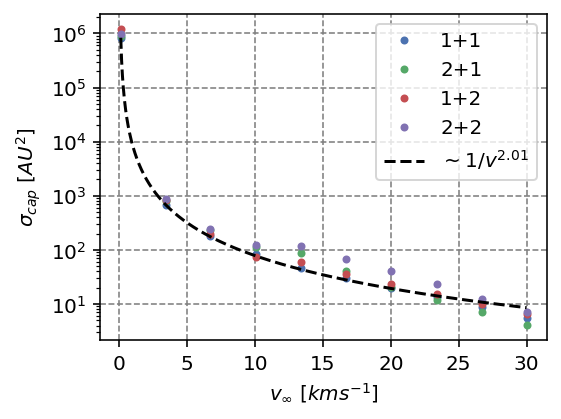

In [11]:
def fitting(x,a,b):
    return a/x**b

from scipy import optimize

def end_c(df,aj=2.5):
    N=1000000
    
    mask = df['aj']==aj
    
    x = df['vel'][mask]
    if 'cap' in df:
        nx = N*df['cap']
        er = np.sqrt(nx)/N
        y= (np.pi*df['b_max']**2*df['cap'])[mask]
        err=(np.pi*df['b_max']**2*er)[mask]
        return x,y, err
    else:
        nx = N*df['b_cap']
        er = np.sqrt(nx)/N
        y=(np.pi*df['b_max']**2*df['b_cap'])[mask]
        err=(np.pi*df['b_max']**2*er)[mask]
        return x, y, err
    
ssx, ssy, sse=end_c(ssdf)
sbx, sby, sbe=end_c(sbdf)
bsx, bsy, bse=end_c(bsdf)
bbx, bby, bbe=end_c(bbdf)

fig=plt.figure(figsize=(4,3))

plt.plot(ssx,ssy,'.',label='1+1')
plt.plot(sbx,sby,'.',label='2+1')
plt.plot(bsx,bsy,'.',label='1+2')
plt.plot(bbx,bby,'.',label='2+2')



a,b = optimize.curve_fit(fitting, ssx, ssy,p0=[10**4, 2])

print(a,b)
v=np.linspace(0.1,30,1000)


plt.plot(v,a[0]/v**a[1],'k--',label='$\sim 1/v^{2.01}$')

plt.yscale('log')
plt.legend()
plt.xlabel('$v_\infty$ [$kms^{-1}$]')
plt.ylabel('$\sigma_{cap}$ [$AU^2$]')
plt.grid(True)
savefig(plt,'capture')

[3306.62400031 -169.85293815]
[160.94988274574155, 1485.8162417165634, 3177.7277105883527, 4780.797208312993, 6452.809395410902, 8066.840569270857, 9738.964701635916, 11360.2241754661, 13032.932447224064, 14738.517920088034, 16398.85983655091] [2.003804077833755, 2.0165517831506463, 2.026574385805774, 2.011803227685324, 2.011815602132439, 2.013331607086269, 2.012944145962154, 2.010889160148397, 2.011824541839082, 2.010914718795744, 2.0088190949097413] [0.020786146569333506, 9.643829749276923, 99.36444954832751, 134.15308714019864, 255.408045756875, 694.4630598636664, 1004.4964677020077, 2077.1473537824636, 3366.3515718377566, 4821.06863738233, 6804.035200501758] [1.5134269998918932e-07, 8.23925871866193e-07, 1.855950823312763e-06, 1.107054139332861e-06, 1.1569263603965677e-06, 2.0128481196384208e-06, 1.9975223571197997e-06, 3.035724231388698e-06, 3.738040522846103e-06, 4.186051045127805e-06, 4.772083856941027e-06]


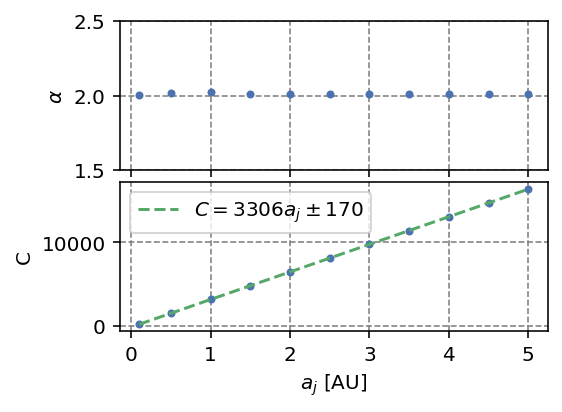

In [30]:
aj=[0.1,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]
c=[]
ec=[]
p=[]
ep=[]
for a in aj:
    ssx, ssy, sse=end_c(ssdf,a)
    a,b = optimize.curve_fit(fitting, ssx, ssy,p0=[10**4, 2])
    c.append(a[0])
    p.append(a[1])
    ec.append(b[0][0])
    ep.append(b[1][1])

     
fig = plt.figure(figsize=(4,3))
ax=fig.add_subplot(2,1,1)
ax.plot(aj,p,'.')    
ax.set_ylim([1.5,2.5])

#empty_string_labels = ['']*len(labels)
ax.set_xticklabels('')
ax.set_ylabel(r'$\alpha$')
plt.grid(True)

ax=fig.add_subplot(2,1,2)
ax.plot(aj,c,'.')   
fit_p=np.polyfit(aj,c,1)
print(fit_p)
ax.plot(aj,np.array(aj)*fit_p[0]+fit_p[1],'--',label='$C=3306a_j\pm 170$')
ax.set_xlabel('$a_j$ [AU]')
ax.set_ylabel('C')
plt.legend()
plt.tight_layout(h_pad=0)
plt.grid(True)
savefig(plt,'capture-fitting')
print(c,p,ec,ep)
    

In [35]:
def v_c_1_1(ms, mj, aj, ms1):
    m_s = ms+mj
    m_i = ms1
    u = m_s*m_i/(m_s + m_i)
    return np.sqrt(1/u*(ms*mj/aj))

def v_c_1_2(ms, mj, aj, ms1, ms2, a_s):
    m_s = ms+mj
    m_i = ms1+ms2
    u = m_s*m_i/(m_s + m_i)
    return np.sqrt(1/u*(ms*mj/aj+ms1*ms2/a_s))

def v_c_2_1(ms, mb, mj, aj, ms1, a_s):
    m_s = ms+mj+mb
    m_i = ms1
    u = m_s*m_i/(m_s + m_i)
    return np.sqrt(1/u*(ms*mj/aj + (ms+mj)*mb/a_s))

def v_c_2_2(ms, mb, mj, aj, ms1, ms2, a_s):
    m_s = ms+mj+mb
    m_i = ms1+ms2
    u = m_s*m_i/(m_s + m_i)
    return np.sqrt(1/u*(ms*mj/aj + (ms+mj)*mb/a_s + ms1*ms2/a_s))

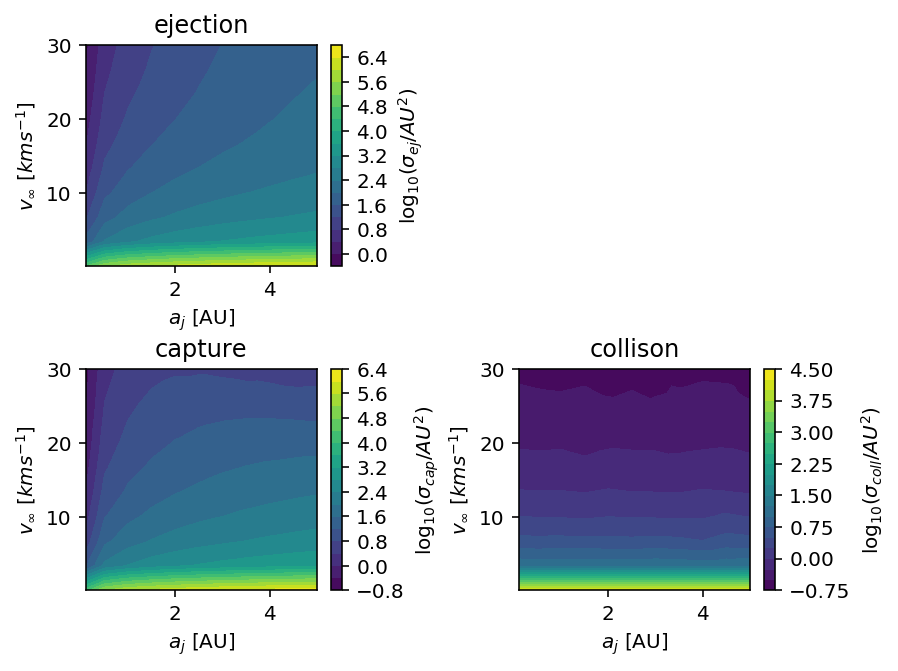

In [43]:

def show_cross(df):
    x=np.array(df['aj'])
    y=(np.array(df['vel']))
    
    
    xlabel='$a_j$ [AU]'
    ylabel='$v_\infty$ [$kms^{-1}$]'
    fig=plt.figure(figsize=(6.4,4.8))
    delta = 0.1
    ax=fig.add_subplot(2,2,1)
    cs= np.log10(np.array(df['b_max'])**2*np.pi*np.array(df['ejection']) + delta)
    im=ax.tricontourf(x,y, cs,20)
    #cb=plt.colorbar(im)
    #cb.set_label('$\log_{10}(\sigma_{ej}/AU^2)$') 
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title('ejection')

   
    
    
    #ax=fig.add_subplot(2,2,2)
    #cs=np.log10(np.array(df['b_max'])**2*np.pi*np.array(df['s_cap']) + delta)
    #im=ax.tricontourf(x,y, cs,20)
    #cb=plt.colorbar(im)
    #cb.set_label('$\log_{10}(\sigma_{cap_s}/AU^2)$') 
    #ax.set_xlabel(xlabel)
    #ax.set_ylabel(ylabel)
    #ax.set_title('single capture')
   
    
    
    ax=fig.add_subplot(2,2,3)
    cs=np.log10(np.array(df['b_max'])**2*np.pi*np.array(df['cap'])+delta)
    im=ax.tricontourf(x,y,cs,20)
    #cb=plt.colorbar(im)
    #cb.set_label('$\log_{10}(\sigma_{cap}/AU^2)$') 
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title('capture')
  
    
    ax=fig.add_subplot(2,2,4)
    cs=np.log10(np.array(df['b_max'])**2*np.pi*( np.array(df['s_coll']) +  np.array(df['s_coll']) )  + delta)
    im=ax.tricontourf(x,y,  cs,20)
    #cb=plt.colorbar(im)
    #cb.set_label('$\log_{10}(\sigma_{coll}/AU^2)$') 
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title('collison')

    #ax=fig.add_subplot(3,2,5)
    #cs=np.log10(np.array(df['b_max'])**2*np.pi*( np.array(df['trans']) )  + delta)
    #im=ax.tricontourf(x,y,  cs,20)
    #cb=plt.colorbar(im)
    #cb.set_label('$\log_{10}(\sigma_{trans}/AU^2)$') 
    #ax.set_xlabel(xlabel)
    #ax.set_ylabel(ylabel)
    #ax.set_title('planet transfer')
    
    plt.tight_layout(h_pad=0,w_pad=0)
    #plt.legend()
    savefig(plt,'solar-normal-ss')
show_cross(ssdf)

In [ ]:

print(df['vel'])

In [ ]:
sns.relplot(x='vel',y='aj',hue='ejection',data=df)